<a href="https://colab.research.google.com/github/hamednasr/CIFAR-10-classification/blob/main/PyTorch_CIFAR_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10 classification using PyTorch

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [43]:
# device= 'cpu'
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [44]:
cifar10 = torchvision.datasets.CIFAR10(root = 'cifar10',download=True)
cifar10

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train

In [45]:
cifar10.data.shape

(50000, 32, 32, 3)

In [46]:
np.max(cifar10.data)

255

In [47]:
images = cifar10.data/np.max(cifar10.data)

In [48]:
labels = cifar10.targets

In [49]:
images.shape

(50000, 32, 32, 3)

In [50]:
len(labels)

50000

In [51]:
images[1].shape

(32, 32, 3)

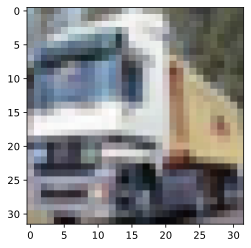

In [52]:
plt.imshow(images[1])

# data preparation for pytorch

In [53]:
images = images.reshape(images.shape[0],3,32,32)

In [54]:
imagesT = torch.tensor(images).float() 

In [55]:
labelsT = torch.tensor(labels).long()

In [56]:
imagesT.shape

torch.Size([50000, 3, 32, 32])

In [57]:
labelsT

tensor([6, 9, 9,  ..., 9, 1, 1])

In [58]:
traindata,testdata,trainlabel,testlabel=train_test_split(imagesT,labelsT,test_size=.1)

In [59]:
trainset = TensorDataset(traindata,trainlabel)

In [148]:
testset = TensorDataset(testdata,testlabel)

In [165]:
batchsize=128
trainloader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)

In [166]:
testloader = DataLoader(testset,batch_size=testset.tensors[1].shape[0])

In [167]:
trainloader.dataset.tensors[0].shape[0]//batchsize

351

## building model:

In [168]:
def CreateModel():
  
  class CNNmodel(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3,20,kernel_size=3,stride=1,padding=1) #first conv layer
      # (32+2*2-5)/1+1=32   max pool:32/2 = 16
      self.batchnorm1 = nn.BatchNorm2d(20)
      
      self.conv2 = nn.Conv2d(20,40,kernel_size=3,stride=1,padding=1) #second conv layer
      #(16+2*2-5)/1+1 = 16  max pool: 16/2 = 8
      self.batchnorm2 = nn.BatchNorm2d(40)

      # self.conv3 = nn.Conv2d(40,80,kernel_size=3,stride=1,padding=1) #third conv layer
      # #(8+2*2-5)/1+1 = 8  max pool: 8/2 = 4
      # self.batchnorm3 = nn.BatchNorm2d(80)

      self.fc1 = nn.Linear(8*8*40,200)

      self.fc2 = nn.Linear(200,50)

      self.out = nn.Linear(50,10)

    
    def forward(self,x):

      x = F.max_pool2d(self.conv1(x),2)
      x= F.leaky_relu(self.batchnorm1(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      x = F.max_pool2d(self.conv2(x),2)
      x= F.leaky_relu(self.batchnorm2(x))
      x = F.dropout(x, p=0.2, training = self.training) 

      # x = F.max_pool2d(self.conv3(x),2)
      # x= F.leaky_relu(self.batchnorm3(x))
      # x = F.dropout(x, p=0.2, training = self.training) 

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x, p=0.5, training = self.training)

      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x, p=0.5, training = self.training)
      
      x = self.out(x)      
      
      return x

  CNN = CNNmodel()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(params=CNN.parameters(), lr = 0.001)

  return CNN, lossfun, optimizer

## Sanity checking of the model:

In [169]:
X = torch.randn(5,3,32,32)
CNN, lossfun, optimizer = CreateModel()
yhat = CNN(X)
print(yhat.shape)
print(torch.argmax(yhat,1))

torch.Size([5, 10])
tensor([3, 3, 3, 3, 7])


## Train the model:

In [170]:
epochs = 20

def TrainModel():

  CNN, lossfun, optimizer = CreateModel()
  CNN.to(device)

  trainacc = []
  testacc = []
  trainloss = []
  testloss = []

  for i in range(epochs):
    
    CNN.train()

    batchloss = []
    batchacc = []

    for X, y in trainloader:

      X = X.to(device)
      y = y.to(device)
      
      yhat = CNN(X)

      loss = lossfun(yhat,y)
      batchloss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

      batchacc.append(100*torch.mean(((torch.argmax(yhat,1)==y).float())).item())

    trainloss.append(np.mean(batchloss))
    trainacc.append(np.mean(batchacc))

    CNN.eval()
    X,y = next(iter(testloader))
    X = X.to(device)
    y = y.to(device)
    yhat = CNN(X)
    testloss.append(lossfun(yhat,y).item())
    testacc.append( 100*torch.mean(((torch.argmax(yhat,1)==y).float())).item() )

  return trainacc, testacc, trainloss, testloss

In [171]:
trainacc, testacc, trainloss, testloss = TrainModel()

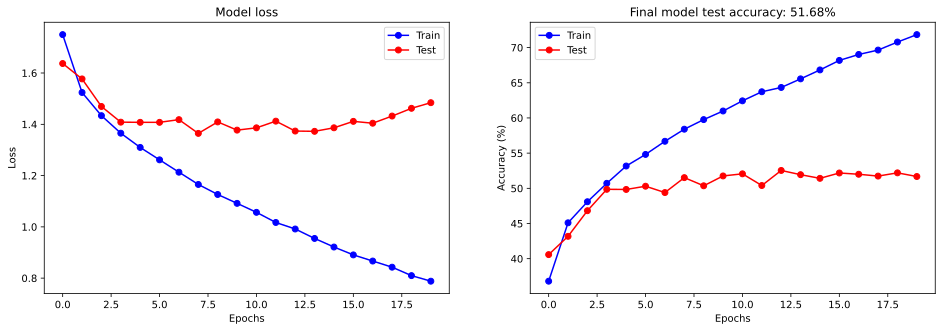

In [172]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss,'bo-',label='Train')
ax[0].plot(testloss,'ro-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainacc,'bo-',label='Train')
ax[1].plot(testacc,'ro-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testacc[-1]:.2f}%')
ax[1].legend()

plt.show()